In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


CS-464 Machine Learning Project - Group 10

Amazon Product Review Sentiment Analysis

Dataset: https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews

In [ ]:
!ls "/content/gdrive/MyDrive/CS-464: Introduction to Machine Learning/Project/"

'Copy of project.ipynb'		 word2vec_embeddings.model.syn1neg.npy
 fully_connected_layer.ipynb	 word2vec_embeddings.model.wv.vectors.npy
 preprocessed_dataset.csv	 word2vec_embeddings_old.model
 preprocessed_dataset_stem.csv	 word2vec_embeddings_sg.model
 project.ipynb			 word2vec_embeddings_sg.model.syn1neg.npy
 Reviews.csv			 word2vec_embeddings_sg.model.wv.vectors.npy
 word2vec_embeddings.model	 word2vec_with_sg.ipynb


In [ ]:
import os
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, punkt
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
import nltk
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from gensim.models import Word2Vec
from nltk.stem import PorterStemmer
nltk.download("punkt")
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
dataset_dir = '/content/gdrive/MyDrive/CS-464: Introduction to Machine Learning/Project/'
csv_path = os.path.join(dataset_dir, 'Reviews.csv')
df = pd.read_csv(csv_path)
df.head(3)

In [ ]:
# Get the number of entries
num_entries = df.shape[0]

# Print the result
print("Number of entries: ", num_entries)

# Check for null values in the 'Score' column
num_null = df['Score'].isnull().sum()

if num_null == 0:
    print("There are no null values in the 'Score' column.")
else:
    print(f"There are {num_null} null values in the 'Score' column.")

In [ ]:
# Read in the CSV file and select only the required columns
df = pd.read_csv(csv_path, usecols=["Score", "Text"])

# Add a new 'Label' column based on the 'Score' column
df["Label"] = pd.cut(df["Score"], bins=[-float("inf"), 2, 3, float("inf")], labels=["negative", "neutral", "positive"])

# Save the labeled dataset to a new CSV file
df.head()

In [ ]:
# Count the number of reviews in each class
class_counts = df["Label"].value_counts()

# Create a histogram of the class distribution
plt.bar(class_counts.index, class_counts.values)

# Add labels and title
plt.xlabel("Class")
plt.ylabel("Number of Reviews")
plt.title("Class Distribution")

# Add text labels above each bar
for i, count in enumerate(class_counts.values):
    plt.text(i, count+50, str(count), ha='center', fontsize=10)

# Show the plot
plt.show()

In [ ]:
stemmer = PorterStemmer()

# Remove punctuation
df['Text'] = df['Text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Convert all text to lowercase
df['Text'] = df['Text'].apply(lambda x: x.lower())

# Tokenize the text data
df['Text'] = df['Text'].apply(lambda x: word_tokenize(x))

# Remove stop words
stop_words = set(stopwords.words('english'))
df['Text'] = df['Text'].apply(lambda x: [word for word in x if word not in stop_words])

# Stemming
df['Text'] = df['Text'].apply(lambda x: [stemmer.stem(word) for word in x])

In [ ]:
df.to_csv('/content/gdrive/MyDrive/CS-464: Introduction to Machine Learning/Project/preprocessed_dataset.csv', index=False)

In [ ]:
file_path = '/content/gdrive/MyDrive/CS-464: Introduction to Machine Learning/Project/preprocessed_dataset_stem.csv'
df_stem = pd.read_csv(file_path)
df_stem.head()

,Score,Text,Label
0,5,"['bought', 'sever', 'vital', 'can', 'dog', 'fo...",positive
1,1,"['product', 'arriv', 'label', 'jumbo', 'salt',...",negative
2,4,"['confect', 'around', 'centuri', 'light', 'pil...",positive
3,2,"['look', 'secret', 'ingredi', 'robitussin', 'b...",negative
4,5,"['great', 'taffi', 'great', 'price', 'wide', '...",positive


In [ ]:
# Split into train and test sets (80-20 split)
train_data, test_data, train_labels, test_labels = train_test_split(df_stem['Text'], df_stem['Label'], test_size=0.2, random_state=42)

# Split train data into train and validation sets (90-10 split)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)

In [ ]:
# print(train_labels)
# counts = train_labels.value_counts()
# print(counts)
sentences = train_data.apply(eval).tolist()
print(sentences[1])

['never', 'brazil', 'nut', 'say', 'love', 'high', 'fat', 'content', 'somewhat', 'moder', 'howev', 'health', 'benefit', 'eat', 'work', 'excel', 'snack', 'food']


In [ ]:
# Convert train_data to list of sentences (each sentence is a list of words)

# Set the parameters for the Word2Vec model
vector_size = 100  # dimensionality of the word vectors
window_size = 5  # maximum distance between the current and predicted word within a sentence
min_count = 5  # minimum frequency of a word to be included in the vocabulary
workers = 4  # number of worker threads to train the model

# Train the Word2Vec model on the sentences
model = Word2Vec(sentences, vector_size=vector_size, window=window_size, min_count=min_count, workers=workers)

In [ ]:
model.save('/content/gdrive/MyDrive/CS-464: Introduction to Machine Learning/Project/word2vec_embeddings_old.model')

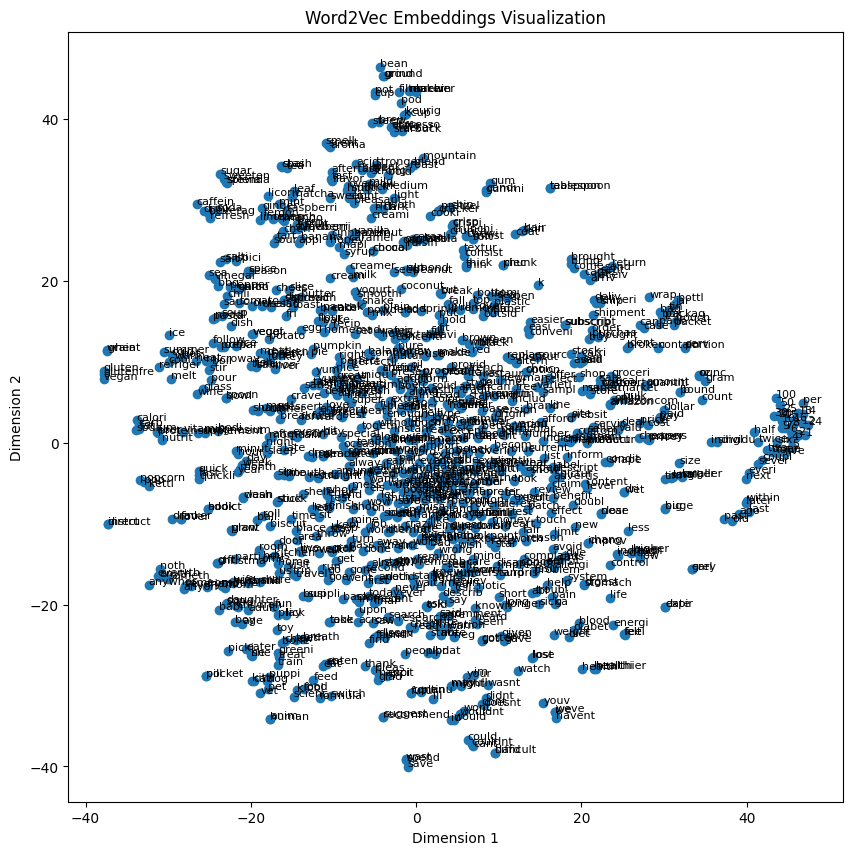

In [ ]:
w2v_model = Word2Vec.load('/content/gdrive/MyDrive/CS-464: Introduction to Machine Learning/Project/word2vec_embeddings_old.model')

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# Get the word embeddings
word_embeddings = w2v_model.wv

# Choose a subset of words for visualization
words_to_visualize = list(word_embeddings.key_to_index.keys())[:1000]

# Get the embeddings for the selected words
embeddings_to_visualize = word_embeddings[words_to_visualize]

# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_to_visualize)
# Create a scatter plot of the embeddings
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
for i, word in enumerate(words_to_visualize):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)
plt.title("Word2Vec Embeddings Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()



In [ ]:
word_embeddings.most_similar(positive="great")

[('fantast', 0.8169080018997192),
 ('excel', 0.80169278383255),
 ('good', 0.7968287467956543),
 ('awesom', 0.7892809510231018),
 ('terrif', 0.7513600587844849),
 ('wonder', 0.7494795322418213),
 ('nice', 0.7204874753952026),
 ('perfect', 0.6945949196815491),
 ('fabul', 0.6798199415206909),
 ('amaz', 0.6281005144119263)]

In [ ]:
word_embeddings.most_similar(positive="vitamin")

[('vit', 0.746522068977356),
 ('multivitamin', 0.6518022418022156),
 ('calcium', 0.6405066251754761),
 ('b12', 0.6355392932891846),
 ('vitaminsbr', 0.6312920451164246),
 ('miner', 0.6277302503585815),
 ('potassium', 0.6216518878936768),
 ('b6', 0.6169264316558838),
 ('c', 0.6053400635719299),
 ('chromium', 0.6020550727844238)]

In [ ]:
word_embeddings.most_similar(positive="size")

[('sizebr', 0.6402103900909424),
 ('bites', 0.6086829900741577),
 ('smaller', 0.580304741859436),
 ('quantiti', 0.5533100366592407),
 ('bigger', 0.543297290802002),
 ('amount', 0.5298674702644348),
 ('small', 0.5225540399551392),
 ('larg', 0.5161583423614502),
 ('diamet', 0.5004866123199463),
 ('larger', 0.49632230401039124)]

In [ ]:
print(train_labels)

254586    negative
366121    positive
124365    positive
40147     positive
361362    positive
            ...   
52893     positive
442439    positive
154660    positive
149731    positive
522494    positive
Name: Label, Length: 409286, dtype: object


In [ ]:
train_data = train_data.apply(eval).tolist()
val_data = val_data.apply(eval).tolist()

In [ ]:
test_data = test_data.apply(eval).tolist()

In [ ]:
len(test_data)

113691

In [ ]:
def get_embedding(word):
    try:
        return w2v_model.wv[word]
    except KeyError:
        # Return a vector of zeros if the word is not in the model vocabulary
        return np.zeros((100,))

# Transform the text data to Word2Vec embeddings
train_embeddings = np.array([np.mean([get_embedding(word) for word in words], axis=0) for words in train_data])
val_embeddings = np.array([np.mean([get_embedding(word) for word in words], axis=0) for words in val_data])
test_embeddings = np.array([np.mean([get_embedding(word) for word in words], axis=0) for words in test_data])

# Multinomial Naive Bayes

In [ ]:
min_embedding = np.min(train_embeddings)
max_embedding = np.max(train_embeddings)
max_range = 100  # Set the maximum range for the scaled values
train_embeddings_scaled = (train_embeddings - min_embedding) / (max_embedding - min_embedding) * max_range
val_embeddings_scaled = (val_embeddings - min_embedding) / (max_embedding - min_embedding) * max_range

# Train a Multinomial Naive Bayes model on the Word2Vec embeddings
mnb_model = MultinomialNB()
mnb_model.fit(train_embeddings_scaled, train_labels)

# Evaluate the trained model on the validation data
val_predictions = mnb_model.predict(val_embeddings_scaled)
overall_accuracy = accuracy_score(val_labels, val_predictions)
f1 = f1_score(val_labels, val_predictions, average='weighted')
confusion_mat = confusion_matrix(val_labels, val_predictions)

Overall accuracy: 0.8022
F1 score: 0.7701


<Axes: >

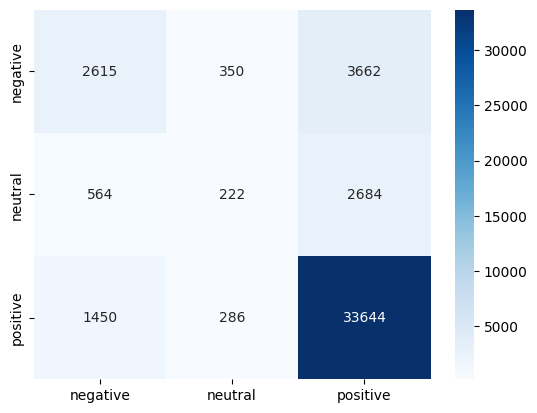

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Print overall accuracy
print(f"Overall accuracy: {overall_accuracy:.4f}")

# Print the F1 score
print(f"F1 score: {f1:.4f}")

cm = confusion_matrix(val_labels, val_predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])

# Gaussian Naive Bayes

In [ ]:

# Train a Gaussian Naive Bayes model on the Word2Vec embeddings
gnb_model = GaussianNB()
gnb_model.fit(train_embeddings, train_labels)

# Evaluate the trained model on the validation data
val_predictions = gnb_model.predict(val_embeddings)
overall_accuracy = accuracy_score(val_labels, val_predictions)
f1 = f1_score(val_labels, val_predictions, average='weighted')
confusion_mat = confusion_matrix(val_labels, val_predictions)

Overall accuracy: 0.6766
F1 score: 0.7182


<Axes: >

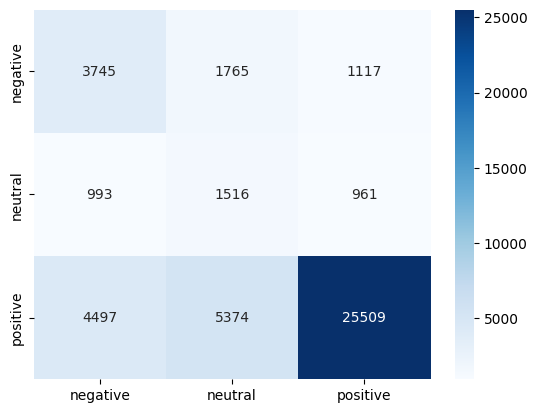

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Print overall accuracy
print(f"Overall accuracy: {overall_accuracy:.4f}")

# Print the F1 score
print(f"F1 score: {f1:.4f}")

cm = confusion_matrix(val_labels, val_predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'neutral', 'positive']
            , yticklabels=['negative', 'neutral', 'positive'])

In [ ]:
# Evaluate the trained model on the validation data
test_predictions = gnb_model.predict(test_embeddings)
overall_accuracy = accuracy_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions, average='weighted')

Overall accuracy: 0.6772
F1 score: 0.7196


<Axes: >

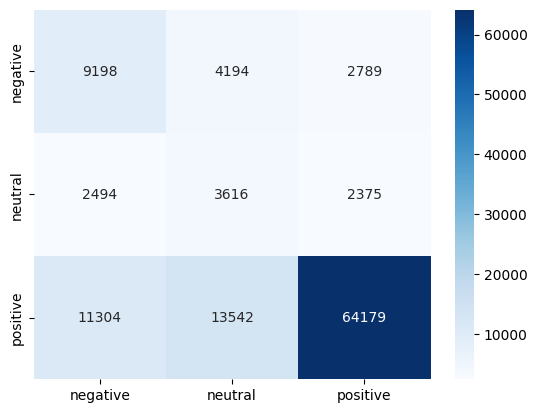

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Print overall accuracy
print(f"Overall accuracy: {overall_accuracy:.4f}")

# Print the F1 score
print(f"F1 score: {f1:.4f}")

cm = confusion_matrix(test_labels, test_predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train a Gaussian Naive Bayes model on the Word2Vec embeddings
lr_model = LogisticRegression()
lr_model.fit(train_embeddings, train_labels)

# Evaluate the trained model on the validation data
val_predictions = lr_model.predict(val_embeddings)
overall_accuracy = accuracy_score(val_labels, val_predictions)
f1 = f1_score(val_labels, val_predictions, average='weighted')
confusion_mat = confusion_matrix(val_labels, val_predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Overall accuracy: 0.8368
F1 score: 0.8054


<Axes: >

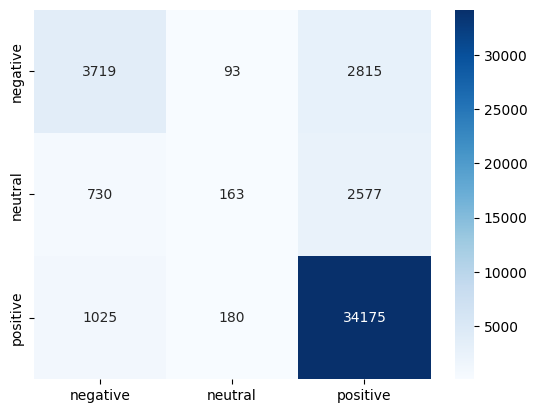

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Print overall accuracy
print(f"Overall accuracy: {overall_accuracy:.4f}")

# Print the F1 score
print(f"F1 score: {f1:.4f}")

cm = confusion_matrix(val_labels, val_predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])

In [ ]:
# Evaluate the trained model on the validation data
test_predictions = lr_model.predict(test_embeddings)
overall_accuracy = accuracy_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions, average='weighted')

Overall accuracy: 0.8399
F1 score: 0.8095


<Axes: >

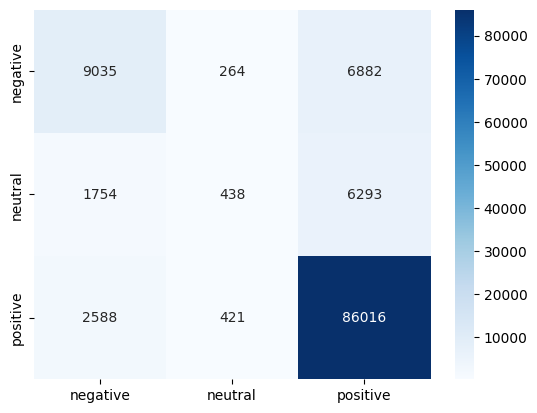

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Print overall accuracy
print(f"Overall accuracy: {overall_accuracy:.4f}")

# Print the F1 score
print(f"F1 score: {f1:.4f}")

cm = confusion_matrix(test_labels, test_predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

In [ ]:
# encode the labels as
# 0 -> negative
# 1 -> neutral
# 2 -> positive
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)
test_labels = label_encoder.transform(test_labels)

# LR = 0.0001

In [ ]:
# Prepare the data
train_embeddings_torch = torch.tensor(train_embeddings, dtype=torch.float32)
train_labels_torch = torch.tensor(train_labels, dtype=torch.long)
val_embeddings_torch = torch.tensor(val_embeddings, dtype=torch.float32)
val_labels_torch = torch.tensor(val_labels, dtype=torch.long)

train_dataset = TensorDataset(train_embeddings_torch, train_labels_torch)
val_dataset = TensorDataset(val_embeddings_torch, val_labels_torch)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the model architecture
input_size = train_embeddings_torch.shape[1]  # Assuming train_embeddings has shape (num_samples, embedding_dim)
hidden_size = 128
num_classes = 3
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, num_classes)
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Train the model
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Activation Function: ReLU")
print("Learning Rate: 0.0001")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for embeddings, labels in train_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, labels in val_loader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print training and validation metrics for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {(correct/total)*100:.2f}%")

from sklearn.metrics import f1_score
val_predictions = []
with torch.no_grad():
    for embeddings, labels in val_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        outputs = model(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions.extend(predicted.cpu().numpy())
val_labels = val_labels_torch.cpu().numpy()
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"F1 Score: {f1:.4f}")

Activation Function: ReLU
Learning Rate: 0.0001
Epoch 1/25 | Train Loss: 0.4495 | Val Loss: 0.4271 | Val Acc: 84.08%
Epoch 2/25 | Train Loss: 0.4214 | Val Loss: 0.4203 | Val Acc: 84.26%
Epoch 3/25 | Train Loss: 0.4149 | Val Loss: 0.4147 | Val Acc: 84.49%
Epoch 4/25 | Train Loss: 0.4103 | Val Loss: 0.4109 | Val Acc: 84.55%
Epoch 5/25 | Train Loss: 0.4065 | Val Loss: 0.4077 | Val Acc: 84.70%
Epoch 6/25 | Train Loss: 0.4034 | Val Loss: 0.4061 | Val Acc: 84.75%
Epoch 7/25 | Train Loss: 0.4007 | Val Loss: 0.4040 | Val Acc: 84.85%
Epoch 8/25 | Train Loss: 0.3983 | Val Loss: 0.4022 | Val Acc: 84.83%
Epoch 9/25 | Train Loss: 0.3960 | Val Loss: 0.4024 | Val Acc: 84.81%
Epoch 10/25 | Train Loss: 0.3939 | Val Loss: 0.3999 | Val Acc: 85.06%
Epoch 11/25 | Train Loss: 0.3921 | Val Loss: 0.4003 | Val Acc: 85.01%
Epoch 12/25 | Train Loss: 0.3904 | Val Loss: 0.3973 | Val Acc: 85.04%
Epoch 13/25 | Train Loss: 0.3888 | Val Loss: 0.3970 | Val Acc: 85.14%
Epoch 14/25 | Train Loss: 0.3873 | Val Loss: 0.3951

# LR = 0.001

In [ ]:
# Prepare the data
train_embeddings_torch = torch.tensor(train_embeddings, dtype=torch.float32)
train_labels_torch = torch.tensor(train_labels, dtype=torch.long)
val_embeddings_torch = torch.tensor(val_embeddings, dtype=torch.float32)
val_labels_torch = torch.tensor(val_labels, dtype=torch.long)

train_dataset = TensorDataset(train_embeddings_torch, train_labels_torch)
val_dataset = TensorDataset(val_embeddings_torch, val_labels_torch)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the model architecture
input_size = train_embeddings_torch.shape[1]
hidden_size = 128
num_classes = 3
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, num_classes)
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Activation Function: ReLU")
print("Learning Rate: 0.001")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for embeddings, labels in train_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, labels in val_loader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print training and validation metrics for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {(correct/total)*100:.2f}%")

from sklearn.metrics import f1_score
val_predictions = []
with torch.no_grad():
    for embeddings, labels in val_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        outputs = model(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions.extend(predicted.cpu().numpy())
val_labels = val_labels_torch.cpu().numpy()
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"F1 Score: {f1:.4f}")

Activation Function: ReLU
Learning Rate: 0.001
Epoch 1/25 | Train Loss: 0.4250 | Val Loss: 0.4112 | Val Acc: 84.61%
Epoch 2/25 | Train Loss: 0.4070 | Val Loss: 0.4050 | Val Acc: 84.71%
Epoch 3/25 | Train Loss: 0.3986 | Val Loss: 0.4010 | Val Acc: 85.01%
Epoch 4/25 | Train Loss: 0.3923 | Val Loss: 0.3961 | Val Acc: 85.17%
Epoch 5/25 | Train Loss: 0.3876 | Val Loss: 0.3954 | Val Acc: 85.23%
Epoch 6/25 | Train Loss: 0.3838 | Val Loss: 0.3949 | Val Acc: 85.29%
Epoch 7/25 | Train Loss: 0.3807 | Val Loss: 0.3923 | Val Acc: 85.39%
Epoch 8/25 | Train Loss: 0.3776 | Val Loss: 0.3925 | Val Acc: 85.41%
Epoch 9/25 | Train Loss: 0.3750 | Val Loss: 0.3953 | Val Acc: 85.49%
Epoch 10/25 | Train Loss: 0.3731 | Val Loss: 0.3937 | Val Acc: 85.46%
Epoch 11/25 | Train Loss: 0.3708 | Val Loss: 0.3935 | Val Acc: 85.29%
Epoch 12/25 | Train Loss: 0.3692 | Val Loss: 0.4000 | Val Acc: 85.24%
Epoch 13/25 | Train Loss: 0.3676 | Val Loss: 0.3889 | Val Acc: 85.68%
Epoch 14/25 | Train Loss: 0.3663 | Val Loss: 0.4017 

In [ ]:
# Prepare the data
train_embeddings_torch = torch.tensor(train_embeddings, dtype=torch.float32)
train_labels_torch = torch.tensor(train_labels, dtype=torch.long)
val_embeddings_torch = torch.tensor(val_embeddings, dtype=torch.float32)
val_labels_torch = torch.tensor(val_labels, dtype=torch.long)

train_dataset = TensorDataset(train_embeddings_torch, train_labels_torch)
val_dataset = TensorDataset(val_embeddings_torch, val_labels_torch)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the model architecture
input_size = train_embeddings_torch.shape[1]  # Assuming train_embeddings has shape (num_samples, embedding_dim)
hidden_size = 256
num_classes = 3
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, num_classes)
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Activation Function: ReLU")
print("Learning Rate: 0.001")
print("Hidden Size: 256")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for embeddings, labels in train_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, labels in val_loader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print training and validation metrics for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {(correct/total)*100:.2f}%")

from sklearn.metrics import f1_score
val_predictions = []
with torch.no_grad():
    for embeddings, labels in val_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        outputs = model(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions.extend(predicted.cpu().numpy())
val_labels = val_labels_torch.cpu().numpy()
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"F1 Score: {f1:.4f}")

Activation Function: ReLU
Learning Rate: 0.001
Hidden Size: 256
Epoch 1/25 | Train Loss: 0.4135 | Val Loss: 0.4059 | Val Acc: 84.81%
Epoch 2/25 | Train Loss: 0.3994 | Val Loss: 0.4026 | Val Acc: 84.93%
Epoch 3/25 | Train Loss: 0.3902 | Val Loss: 0.4008 | Val Acc: 85.03%
Epoch 4/25 | Train Loss: 0.3826 | Val Loss: 0.3965 | Val Acc: 85.13%
Epoch 5/25 | Train Loss: 0.3763 | Val Loss: 0.3917 | Val Acc: 85.37%
Epoch 6/25 | Train Loss: 0.3705 | Val Loss: 0.3910 | Val Acc: 85.57%
Epoch 7/25 | Train Loss: 0.3655 | Val Loss: 0.3906 | Val Acc: 85.57%
Epoch 8/25 | Train Loss: 0.3611 | Val Loss: 0.3895 | Val Acc: 85.80%
Epoch 9/25 | Train Loss: 0.3568 | Val Loss: 0.3864 | Val Acc: 85.68%
Epoch 10/25 | Train Loss: 0.3533 | Val Loss: 0.3875 | Val Acc: 85.85%
Epoch 11/25 | Train Loss: 0.3502 | Val Loss: 0.3888 | Val Acc: 85.69%
Epoch 12/25 | Train Loss: 0.3466 | Val Loss: 0.3892 | Val Acc: 85.89%
Epoch 13/25 | Train Loss: 0.3442 | Val Loss: 0.3884 | Val Acc: 86.00%
Epoch 14/25 | Train Loss: 0.3415 | 

In [ ]:
# Prepare the data
train_embeddings_torch = torch.tensor(train_embeddings, dtype=torch.float32)
train_labels_torch = torch.tensor(train_labels, dtype=torch.long)
val_embeddings_torch = torch.tensor(val_embeddings, dtype=torch.float32)
val_labels_torch = torch.tensor(val_labels, dtype=torch.long)

train_dataset = TensorDataset(train_embeddings_torch, train_labels_torch)
val_dataset = TensorDataset(val_embeddings_torch, val_labels_torch)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the model architecture
input_size = train_embeddings_torch.shape[1]  # Assuming train_embeddings has shape (num_samples, embedding_dim)
hidden_size = 64
num_classes = 3
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, num_classes)
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Activation Function: ReLU")
print("Learning Rate: 0.001")
print("Hidden Size: 64")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for embeddings, labels in train_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, labels in val_loader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print training and validation metrics for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {(correct/total)*100:.2f}%")

from sklearn.metrics import f1_score
val_predictions = []
with torch.no_grad():
    for embeddings, labels in val_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        outputs = model(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions.extend(predicted.cpu().numpy())
val_labels = val_labels_torch.cpu().numpy()
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"F1 Score: {f1:.4f}")

Activation Function: ReLU
Learning Rate: 0.001
Hidden Size: 64
Epoch 1/25 | Train Loss: 0.4275 | Val Loss: 0.4163 | Val Acc: 84.35%
Epoch 2/25 | Train Loss: 0.4115 | Val Loss: 0.4092 | Val Acc: 84.61%
Epoch 3/25 | Train Loss: 0.4050 | Val Loss: 0.4094 | Val Acc: 84.76%
Epoch 4/25 | Train Loss: 0.4001 | Val Loss: 0.4040 | Val Acc: 84.82%
Epoch 5/25 | Train Loss: 0.3964 | Val Loss: 0.4016 | Val Acc: 84.99%
Epoch 6/25 | Train Loss: 0.3936 | Val Loss: 0.4030 | Val Acc: 84.87%
Epoch 7/25 | Train Loss: 0.3912 | Val Loss: 0.3990 | Val Acc: 85.08%
Epoch 8/25 | Train Loss: 0.3895 | Val Loss: 0.3971 | Val Acc: 85.15%
Epoch 9/25 | Train Loss: 0.3880 | Val Loss: 0.3982 | Val Acc: 85.21%
Epoch 10/25 | Train Loss: 0.3867 | Val Loss: 0.3979 | Val Acc: 85.25%
Epoch 11/25 | Train Loss: 0.3853 | Val Loss: 0.3961 | Val Acc: 85.28%
Epoch 12/25 | Train Loss: 0.3845 | Val Loss: 0.3968 | Val Acc: 85.31%
Epoch 13/25 | Train Loss: 0.3834 | Val Loss: 0.3967 | Val Acc: 85.32%
Epoch 14/25 | Train Loss: 0.3826 | V

In [ ]:
# Prepare the data
train_embeddings_torch = torch.tensor(train_embeddings, dtype=torch.float32)
train_labels_torch = torch.tensor(train_labels, dtype=torch.long)
val_embeddings_torch = torch.tensor(val_embeddings, dtype=torch.float32)
val_labels_torch = torch.tensor(val_labels, dtype=torch.long)

train_dataset = TensorDataset(train_embeddings_torch, train_labels_torch)
val_dataset = TensorDataset(val_embeddings_torch, val_labels_torch)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the model architecture
input_size = train_embeddings_torch.shape[1]  # Assuming train_embeddings has shape (num_samples, embedding_dim)
hidden_size = 512
num_classes = 3
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, num_classes)
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Activation Function: ReLU")
print("Learning Rate: 0.001")
print("Hidden Size: 512")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for embeddings, labels in train_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, labels in val_loader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print training and validation metrics for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {(correct/total)*100:.2f}%")

from sklearn.metrics import f1_score
val_predictions = []
with torch.no_grad():
    for embeddings, labels in val_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        outputs = model(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions.extend(predicted.cpu().numpy())
val_labels = val_labels_torch.cpu().numpy()
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"F1 Score: {f1:.4f}")

Activation Function: ReLU
Learning Rate: 0.001
Hidden Size: 512
Epoch 1/25 | Train Loss: 0.4271 | Val Loss: 0.4151 | Val Acc: 84.46%
Epoch 2/25 | Train Loss: 0.4100 | Val Loss: 0.4089 | Val Acc: 84.69%
Epoch 3/25 | Train Loss: 0.4031 | Val Loss: 0.4048 | Val Acc: 84.81%
Epoch 4/25 | Train Loss: 0.3987 | Val Loss: 0.4049 | Val Acc: 84.80%
Epoch 5/25 | Train Loss: 0.3956 | Val Loss: 0.4030 | Val Acc: 84.83%
Epoch 6/25 | Train Loss: 0.3927 | Val Loss: 0.3985 | Val Acc: 84.90%
Epoch 7/25 | Train Loss: 0.3907 | Val Loss: 0.3994 | Val Acc: 85.06%
Epoch 8/25 | Train Loss: 0.3890 | Val Loss: 0.3964 | Val Acc: 85.16%
Epoch 9/25 | Train Loss: 0.3875 | Val Loss: 0.3989 | Val Acc: 84.96%
Epoch 10/25 | Train Loss: 0.3864 | Val Loss: 0.3992 | Val Acc: 85.02%
Epoch 11/25 | Train Loss: 0.3850 | Val Loss: 0.4049 | Val Acc: 84.85%
Epoch 12/25 | Train Loss: 0.3839 | Val Loss: 0.3964 | Val Acc: 85.11%
Epoch 13/25 | Train Loss: 0.3830 | Val Loss: 0.3943 | Val Acc: 85.30%
Epoch 14/25 | Train Loss: 0.3823 | 

# Two Hidden Layers

In [ ]:
# Prepare the data
train_embeddings_torch = torch.tensor(train_embeddings, dtype=torch.float32)
train_labels_torch = torch.tensor(train_labels, dtype=torch.long)
val_embeddings_torch = torch.tensor(val_embeddings, dtype=torch.float32)
val_labels_torch = torch.tensor(val_labels, dtype=torch.long)

train_dataset = TensorDataset(train_embeddings_torch, train_labels_torch)
val_dataset = TensorDataset(val_embeddings_torch, val_labels_torch)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the model architecture
input_size = train_embeddings_torch.shape[1]  # Assuming train_embeddings has shape (num_samples, embedding_dim)
hidden_size = 256
num_classes = 3
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, num_classes)
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Activation Function: ReLU")
print("Learning Rate: 0.001")
print("Hidden Size: 256")
print("Two Hidden Layers")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for embeddings, labels in train_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, labels in val_loader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print training and validation metrics for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {(correct/total)*100:.2f}%")

from sklearn.metrics import f1_score
val_predictions = []
with torch.no_grad():
    for embeddings, labels in val_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        outputs = model(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions.extend(predicted.cpu().numpy())
val_labels = val_labels_torch.cpu().numpy()
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"F1 Score: {f1:.4f}")

Activation Function: ReLU
Learning Rate: 0.001
Hidden Size: 256
Two Hidden Layers
Epoch 1/25 | Train Loss: 0.4211 | Val Loss: 0.4088 | Val Acc: 84.62%
Epoch 2/25 | Train Loss: 0.3989 | Val Loss: 0.3973 | Val Acc: 84.86%
Epoch 3/25 | Train Loss: 0.3851 | Val Loss: 0.3918 | Val Acc: 85.42%
Epoch 4/25 | Train Loss: 0.3736 | Val Loss: 0.3821 | Val Acc: 85.74%
Epoch 5/25 | Train Loss: 0.3616 | Val Loss: 0.3832 | Val Acc: 85.83%
Epoch 6/25 | Train Loss: 0.3502 | Val Loss: 0.3779 | Val Acc: 86.08%
Epoch 7/25 | Train Loss: 0.3403 | Val Loss: 0.3767 | Val Acc: 86.33%
Epoch 8/25 | Train Loss: 0.3311 | Val Loss: 0.3739 | Val Acc: 86.60%
Epoch 9/25 | Train Loss: 0.3225 | Val Loss: 0.3767 | Val Acc: 86.44%
Epoch 10/25 | Train Loss: 0.3146 | Val Loss: 0.3754 | Val Acc: 86.63%
Epoch 11/25 | Train Loss: 0.3076 | Val Loss: 0.3769 | Val Acc: 86.73%
Epoch 12/25 | Train Loss: 0.3009 | Val Loss: 0.3828 | Val Acc: 86.78%
Epoch 13/25 | Train Loss: 0.2951 | Val Loss: 0.3831 | Val Acc: 86.78%
Epoch 14/25 | Tra

# Three hidden layers

In [ ]:
# Prepare the data
train_embeddings_torch = torch.tensor(train_embeddings, dtype=torch.float32)
train_labels_torch = torch.tensor(train_labels, dtype=torch.long)
val_embeddings_torch = torch.tensor(val_embeddings, dtype=torch.float32)
val_labels_torch = torch.tensor(val_labels, dtype=torch.long)

train_dataset = TensorDataset(train_embeddings_torch, train_labels_torch)
val_dataset = TensorDataset(val_embeddings_torch, val_labels_torch)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the model architecture
input_size = train_embeddings_torch.shape[1]  # Assuming train_embeddings has shape (num_samples, embedding_dim)
hidden_size = 256
num_classes = 3
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, num_classes)
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Activation Function: ReLU")
print("Learning Rate: 0.001")
print("Hidden Size: 256")
print("Three Hidden Layers")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for embeddings, labels in train_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, labels in val_loader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print training and validation metrics for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {(correct/total)*100:.2f}%")

from sklearn.metrics import f1_score
val_predictions = []
with torch.no_grad():
    for embeddings, labels in val_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        outputs = model(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions.extend(predicted.cpu().numpy())
val_labels = val_labels_torch.cpu().numpy()
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"F1 Score: {f1:.4f}")

Activation Function: ReLU
Learning Rate: 0.001
Hidden Size: 256
Three Hidden Layers
Epoch 1/25 | Train Loss: 0.4225 | Val Loss: 0.4123 | Val Acc: 84.52%
Epoch 2/25 | Train Loss: 0.4002 | Val Loss: 0.3980 | Val Acc: 84.98%
Epoch 3/25 | Train Loss: 0.3868 | Val Loss: 0.3902 | Val Acc: 85.36%
Epoch 4/25 | Train Loss: 0.3742 | Val Loss: 0.3872 | Val Acc: 85.60%
Epoch 5/25 | Train Loss: 0.3633 | Val Loss: 0.3804 | Val Acc: 85.90%
Epoch 6/25 | Train Loss: 0.3531 | Val Loss: 0.3735 | Val Acc: 86.11%
Epoch 7/25 | Train Loss: 0.3436 | Val Loss: 0.3757 | Val Acc: 86.11%
Epoch 8/25 | Train Loss: 0.3345 | Val Loss: 0.3700 | Val Acc: 86.63%
Epoch 9/25 | Train Loss: 0.3261 | Val Loss: 0.3723 | Val Acc: 86.55%
Epoch 10/25 | Train Loss: 0.3189 | Val Loss: 0.3756 | Val Acc: 86.58%
Epoch 11/25 | Train Loss: 0.3112 | Val Loss: 0.3734 | Val Acc: 86.96%
Epoch 12/25 | Train Loss: 0.3048 | Val Loss: 0.3812 | Val Acc: 87.03%
Epoch 13/25 | Train Loss: 0.2991 | Val Loss: 0.3712 | Val Acc: 87.35%
Epoch 14/25 | T

In [ ]:
# Prepare the data
test_embeddings_torch = torch.tensor(test_embeddings, dtype=torch.float32)
test_labels_torch = torch.tensor(test_labels, dtype=torch.long)
test_dataset = TensorDataset(test_embeddings_torch, test_labels_torch)

# Create data loaders
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Accuracy: 0.8755
F1 Score: 0.8633


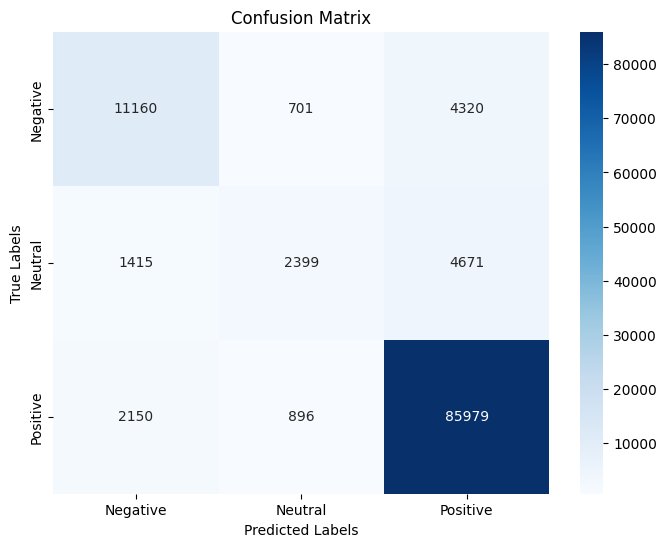

In [ ]:
model.eval()
true_labels = []
predicted_labels = []
with torch.no_grad():
    for embeddings, labels in test_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        outputs = model(embeddings)
        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
for true_label, predicted_label in zip(true_labels, predicted_labels):
    confusion_matrix[true_label][predicted_label] += 1

# Create a heatmap using seaborn
class_names = ['Negative', 'Neutral', 'Positive']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# ReLU Activation Function LR = 0.01

In [ ]:
# Prepare the data
train_embeddings_torch = torch.tensor(train_embeddings, dtype=torch.float32)
train_labels_torch = torch.tensor(train_labels, dtype=torch.long)
val_embeddings_torch = torch.tensor(val_embeddings, dtype=torch.float32)
val_labels_torch = torch.tensor(val_labels, dtype=torch.long)

train_dataset = TensorDataset(train_embeddings_torch, train_labels_torch)
val_dataset = TensorDataset(val_embeddings_torch, val_labels_torch)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the model architecture
input_size = train_embeddings_torch.shape[1]  # Assuming train_embeddings has shape (num_samples, embedding_dim)
hidden_size = 128
num_classes = 3
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, num_classes)
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Train the model
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Activation Function: ReLU")
print("Learning Rate: 0.01")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for embeddings, labels in train_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, labels in val_loader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print training and validation metrics for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {(correct/total)*100:.2f}%")

from sklearn.metrics import f1_score
val_predictions = []
with torch.no_grad():
    for embeddings, labels in val_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        outputs = model(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions.extend(predicted.cpu().numpy())
val_labels = val_labels_torch.cpu().numpy()
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"F1 Score: {f1:.4f}")

Activation Function: ReLU
Learning Rate: 0.01
Epoch 1/25 | Train Loss: 0.4434 | Val Loss: 0.4327 | Val Acc: 83.60%
Epoch 2/25 | Train Loss: 0.4353 | Val Loss: 0.4323 | Val Acc: 83.92%
Epoch 3/25 | Train Loss: 0.4336 | Val Loss: 0.4447 | Val Acc: 83.36%
Epoch 4/25 | Train Loss: 0.4342 | Val Loss: 0.4368 | Val Acc: 83.92%
Epoch 5/25 | Train Loss: 0.4332 | Val Loss: 0.4364 | Val Acc: 83.59%
Epoch 6/25 | Train Loss: 0.4339 | Val Loss: 0.4480 | Val Acc: 83.67%
Epoch 7/25 | Train Loss: 0.4323 | Val Loss: 0.4334 | Val Acc: 83.75%
Epoch 8/25 | Train Loss: 0.4321 | Val Loss: 0.4399 | Val Acc: 83.65%
Epoch 9/25 | Train Loss: 0.4325 | Val Loss: 0.4379 | Val Acc: 83.93%
Epoch 10/25 | Train Loss: 0.4320 | Val Loss: 0.4337 | Val Acc: 84.11%
Epoch 11/25 | Train Loss: 0.4326 | Val Loss: 0.4415 | Val Acc: 83.80%
Epoch 12/25 | Train Loss: 0.4328 | Val Loss: 0.4356 | Val Acc: 83.83%
Epoch 13/25 | Train Loss: 0.4329 | Val Loss: 0.4309 | Val Acc: 83.98%
Epoch 14/25 | Train Loss: 0.4313 | Val Loss: 0.4359 |

# Sigmoid Activation Function with LR = 0.0001

In [ ]:
# Prepare the data
train_embeddings_torch = torch.tensor(train_embeddings, dtype=torch.float32)
train_labels_torch = torch.tensor(train_labels, dtype=torch.long)
val_embeddings_torch = torch.tensor(val_embeddings, dtype=torch.float32)
val_labels_torch = torch.tensor(val_labels, dtype=torch.long)

train_dataset = TensorDataset(train_embeddings_torch, train_labels_torch)
val_dataset = TensorDataset(val_embeddings_torch, val_labels_torch)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the model architecture
input_size = train_embeddings_torch.shape[1]  # Assuming train_embeddings has shape (num_samples, embedding_dim)
hidden_size = 128
num_classes = 3
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, num_classes)
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Train the model
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Activation Function: Sigmoid")
print("Learning Rate: 0.0001")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for embeddings, labels in train_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, labels in val_loader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print training and validation metrics for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {(correct/total)*100:.2f}%")

from sklearn.metrics import f1_score
val_predictions = []
with torch.no_grad():
    for embeddings, labels in val_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        outputs = model(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions.extend(predicted.cpu().numpy())
val_labels = val_labels_torch.cpu().numpy()
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"F1 Score: {f1:.4f}")

Activation Function: Sigmoid
Learning Rate: 0.0001
Epoch 1/25 | Train Loss: 0.4708 | Val Loss: 0.4383 | Val Acc: 83.63%
Epoch 2/25 | Train Loss: 0.4343 | Val Loss: 0.4349 | Val Acc: 83.70%
Epoch 3/25 | Train Loss: 0.4322 | Val Loss: 0.4328 | Val Acc: 83.74%
Epoch 4/25 | Train Loss: 0.4310 | Val Loss: 0.4317 | Val Acc: 83.73%
Epoch 5/25 | Train Loss: 0.4300 | Val Loss: 0.4310 | Val Acc: 83.73%
Epoch 6/25 | Train Loss: 0.4289 | Val Loss: 0.4296 | Val Acc: 83.84%
Epoch 7/25 | Train Loss: 0.4278 | Val Loss: 0.4284 | Val Acc: 83.83%
Epoch 8/25 | Train Loss: 0.4268 | Val Loss: 0.4276 | Val Acc: 83.82%
Epoch 9/25 | Train Loss: 0.4258 | Val Loss: 0.4266 | Val Acc: 83.89%
Epoch 10/25 | Train Loss: 0.4248 | Val Loss: 0.4253 | Val Acc: 83.90%
Epoch 11/25 | Train Loss: 0.4240 | Val Loss: 0.4249 | Val Acc: 83.95%
Epoch 12/25 | Train Loss: 0.4231 | Val Loss: 0.4236 | Val Acc: 83.95%
Epoch 13/25 | Train Loss: 0.4222 | Val Loss: 0.4227 | Val Acc: 84.04%
Epoch 14/25 | Train Loss: 0.4213 | Val Loss: 0.4

In [ ]:
# Prepare the data
train_embeddings_torch = torch.tensor(train_embeddings, dtype=torch.float32)
train_labels_torch = torch.tensor(train_labels, dtype=torch.long)
val_embeddings_torch = torch.tensor(val_embeddings, dtype=torch.float32)
val_labels_torch = torch.tensor(val_labels, dtype=torch.long)

train_dataset = TensorDataset(train_embeddings_torch, train_labels_torch)
val_dataset = TensorDataset(val_embeddings_torch, val_labels_torch)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the model architecture
input_size = train_embeddings_torch.shape[1]  # Assuming train_embeddings has shape (num_samples, embedding_dim)
hidden_size = 128
num_classes = 3
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, num_classes)
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Activation Function: Sigmoid")
print("Learning Rate: 0.001")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for embeddings, labels in train_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, labels in val_loader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print training and validation metrics for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {(correct/total)*100:.2f}%")

from sklearn.metrics import f1_score
val_predictions = []
with torch.no_grad():
    for embeddings, labels in val_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        outputs = model(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions.extend(predicted.cpu().numpy())
val_labels = val_labels_torch.cpu().numpy()
f1 = f1_score(val_labels, val_predictions, average='weighted')  # or 'micro' or 'weighted' depending on your needs
print(f"F1 Score: {f1:.4f}")

Activation Function: Sigmoid
Learning Rate: 0.001
Epoch 1/25 | Train Loss: 0.4374 | Val Loss: 0.4294 | Val Acc: 83.65%
Epoch 2/25 | Train Loss: 0.4217 | Val Loss: 0.4161 | Val Acc: 84.46%
Epoch 3/25 | Train Loss: 0.4123 | Val Loss: 0.4137 | Val Acc: 84.49%
Epoch 4/25 | Train Loss: 0.4054 | Val Loss: 0.4074 | Val Acc: 84.77%
Epoch 5/25 | Train Loss: 0.3995 | Val Loss: 0.4005 | Val Acc: 84.94%
Epoch 6/25 | Train Loss: 0.3946 | Val Loss: 0.4064 | Val Acc: 84.80%
Epoch 7/25 | Train Loss: 0.3900 | Val Loss: 0.3949 | Val Acc: 85.28%
Epoch 8/25 | Train Loss: 0.3862 | Val Loss: 0.3929 | Val Acc: 85.26%
Epoch 9/25 | Train Loss: 0.3825 | Val Loss: 0.3918 | Val Acc: 85.42%
Epoch 10/25 | Train Loss: 0.3794 | Val Loss: 0.3903 | Val Acc: 85.40%
Epoch 11/25 | Train Loss: 0.3766 | Val Loss: 0.3880 | Val Acc: 85.65%
Epoch 12/25 | Train Loss: 0.3739 | Val Loss: 0.3899 | Val Acc: 85.51%
Epoch 13/25 | Train Loss: 0.3715 | Val Loss: 0.3910 | Val Acc: 85.39%
Epoch 14/25 | Train Loss: 0.3693 | Val Loss: 0.38

In [ ]:
# Prepare the data
train_embeddings_torch = torch.tensor(train_embeddings, dtype=torch.float32)
train_labels_torch = torch.tensor(train_labels, dtype=torch.long)
val_embeddings_torch = torch.tensor(val_embeddings, dtype=torch.float32)
val_labels_torch = torch.tensor(val_labels, dtype=torch.long)

train_dataset = TensorDataset(train_embeddings_torch, train_labels_torch)
val_dataset = TensorDataset(val_embeddings_torch, val_labels_torch)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the model architecture
input_size = train_embeddings_torch.shape[1]  # Assuming train_embeddings has shape (num_samples, embedding_dim)
hidden_size = 128
num_classes = 3
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, num_classes)
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Activation Function: Tanh")
print("Learning Rate: 0.001")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for embeddings, labels in train_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, labels in val_loader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print training and validation metrics for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {(correct/total)*100:.2f}%")

from sklearn.metrics import f1_score
val_predictions = []
with torch.no_grad():
    for embeddings, labels in val_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        outputs = model(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions.extend(predicted.cpu().numpy())
val_labels = val_labels_torch.cpu().numpy()
f1 = f1_score(val_labels, val_predictions, average='weighted')  # or 'micro' or 'weighted' depending on your needs
print(f"F1 Score: {f1:.4f}")

Activation Function: Tanh
Learning Rate: 0.001
Epoch 1/25 | Train Loss: 0.4326 | Val Loss: 0.4226 | Val Acc: 84.01%
Epoch 2/25 | Train Loss: 0.4155 | Val Loss: 0.4131 | Val Acc: 84.37%
Epoch 3/25 | Train Loss: 0.4078 | Val Loss: 0.4077 | Val Acc: 84.65%
Epoch 4/25 | Train Loss: 0.4024 | Val Loss: 0.4064 | Val Acc: 84.76%
Epoch 5/25 | Train Loss: 0.3982 | Val Loss: 0.4016 | Val Acc: 84.87%
Epoch 6/25 | Train Loss: 0.3948 | Val Loss: 0.4014 | Val Acc: 84.95%
Epoch 7/25 | Train Loss: 0.3921 | Val Loss: 0.3989 | Val Acc: 84.97%
Epoch 8/25 | Train Loss: 0.3899 | Val Loss: 0.4026 | Val Acc: 84.85%
Epoch 9/25 | Train Loss: 0.3881 | Val Loss: 0.4008 | Val Acc: 84.84%
Epoch 10/25 | Train Loss: 0.3864 | Val Loss: 0.3999 | Val Acc: 85.06%
Epoch 11/25 | Train Loss: 0.3849 | Val Loss: 0.3973 | Val Acc: 85.23%
Epoch 12/25 | Train Loss: 0.3836 | Val Loss: 0.3955 | Val Acc: 85.16%
Epoch 13/25 | Train Loss: 0.3827 | Val Loss: 0.3985 | Val Acc: 85.06%
Epoch 14/25 | Train Loss: 0.3813 | Val Loss: 0.3993 